Examining the dynamics of a snow leopard-wild prey-livestock system using various models

4 patches in total.
1 is a village - has only livestock and snow leopards coming every generation. 
3 wild patches - SL+ wild prey.

Dispersal is uniform between all patches for every time step -either randomly determined or fixed. At every time step, certain snow leopard come into the village and feed on livestock. The resulting increased snow leopard population is re-dispersed across all the wild patches. 

Within each wild patch, the following equations govern the dynamics:

dx/dt=(r*x*(1-((x+j*z)/K)))-(a*x*y)
dy/dt=(c*a*(x+z)-m-b*y-e*z)*y
dz/dt=(p-f*y-2*g*z)

x is the wild prey population density, y is the snow leopard density and z is the livestock density. The equations for x and y are biologically determined, while z is economically determined. I am copying an explanation of the equation for z from the original paper below:

"We treat a pastoralist village as an independent decision making unit trying to maximize the value of its livestock. It first decides which livestock protection and husbandry technologies to use and then decides how many livestock to hold. There are many villages in snow leopard habitat, and we can aggregate over all villages to obtain the net value of livestock holdings as characterized by pz − gz2 − fyz. The parameters g and f reflect the chosen technologies: g indexes the cost of the nonpredation-related livestock husbandry technology chosen, and f indexes the cost of the livestock protection
technology. The parameter p represents the value (or marginal benefit) of holding a head of livestock relative
to the best alternative activity." 

If we differentiate this expression (pz − gz2 − fyz) w.r.t z, we get dz/dt.

Here, the parameters are r (prey growth rate), K (carrying capacity), j (competitive effect of livestock on prey), a(predator’s search rate), c (predator’s nutritional conversion efficiency), m (predator’s metabolic requirements),
b (predator’s interference), e (retaliatory persecution of predator by pastoralists), p (capital value of livestock), 
f (pastoralists’ expenditure in anti-predatory defense for livestock), and g (pastoralists’ expenditure in livestock husbandry, which includes offsetting the effects of competition from wild prey through stall feeding, etc.). For
simplicity, encounter rate and conversion efficiency for both wild prey and livestock are considered as a and c, respectively.


In [1]:
%pylab inline

Populating the interactive namespace from numpy and matplotlib


In [2]:
from pandas import *
import random

In [3]:
#Define the wild patch as an object. A list of variables in the object is here:
#initialC - Initial conditions for that instance of the object.
#finalCW - The overall time-series of all wild objects. Corresponds to 'overallTSW' in the main program.
#finalCV - The overall time-series of the village object. Corresponds to 'overallTSV' in the main program.
#disRate - dispersal rate between patches - both wild and village.
#parmsW - Parameters for the Wild object.


class Wild():
    
    # Initiate the object
    def __init__(self,initialC,finalCW,wildNo):
        self.x=initialC[0][0] # wild prey
        self.y=initialC[1][0] # snow leopard
        self.z=initialC[2][0] # livestock
        
        
        finalCW[wildNo][0].append(self.x)
        finalCW[wildNo][1].append(self.y)
        finalCW[wildNo][2].append(self.z)
        
    # Updating the object    
    def update(self,finalCV,finalCW,disRate,parmsW,wildNo):

        selfDensity=[self.x,self.y,self.z]  #List of all current densities
        
        for i in range(3):
            selfDensity[i]=finalCW[wildNo][i][len(finalCW[wildNo][i])-1] #updating the list before starting new round
        
        #Parameters for the wild object - fis zero here because there is no cost of protection in the wild.
        a=parmsW[0]
        b=parmsW[1]
        c=parmsW[2]
        e=parmsW[3]
        f=parmsW[4]
        j=parmsW[5]
        g=parmsW[6]
        p=parmsW[7]
        K=parmsW[8]
        r=parmsW[9]
        m=parmsW[10]
        
        dt=parmsW[11] #time step size
        
        #Equations defining dynamics within each wild patch. selfDensity has all the current values - 0 is wild prey, 
        #1 is snow leopard and 2 is livestock
        
        dx=(r*selfDensity[0]*(1-((selfDensity[0]+j*selfDensity[2])/K))*dt)-(a*selfDensity[0]*selfDensity[1]*dt)
        dy=(c*a*(selfDensity[0]+selfDensity[2])-m-b*selfDensity[1]-e*selfDensity[2])*selfDensity[1]*dt
        dz=(p-f*selfDensity[1]-2*g*selfDensity[2])*dt
        
        selfDensity[0]=selfDensity[0]+dx
        selfDensity[1]=selfDensity[1]+dy
        selfDensity[2]=selfDensity[2]+dz
        
        # Remove the dispersing population
        for i in range(3):
            selfDensity[i]=selfDensity[i]*(1-disRate)
        
        #Final update to the time series - since negative populations don't make biological sense, I make any negative 
        #population zero.
        
        for i in range(3):
            if selfDensity[i]>0:
                finalCW[wildNo][i].append(selfDensity[i])
            else:
                selfDensity[i]=0
                finalCW[wildNo][i].append(selfDensity[i])
        
# Distribute the dispersed population to the rest of the patches.
# Adding to wild patches
        for i in range(3):
            if i!=wildNo:
                for j in range(3):
                    if j==0:
                        finalCW[i][j][len(finalCW[i][j])-1]=finalCW[i][j][len(finalCW[i][j])-1]+(selfDensity[j]*disRate/2)
                    else:
                        finalCW[i][j][len(finalCW[i][j])-1]=finalCW[i][j][len(finalCW[i][j])-1]+(selfDensity[j]*disRate/3)
        
#Adding to the village patch                
        finalCV[0][len(finalCV[0])-1]=finalCV[0][len(finalCV[0])-1]+(selfDensity[1]*disRate/3)
        finalCV[1][len(finalCV[1])-1]=finalCV[1][len(finalCV[1])-1]+(selfDensity[2]*disRate/3)


In [4]:
#Define the village patch as an object. A list of variables in the object is here:
#initialC - Initial conditions for that instance of the object.
#finalCW - The overall time-series of all wild objects. Corresponds to 'overallTSW' in the main program.
#finalCV - The overall time-series of the village object. Corresponds to 'overallTSV' in the main program.
#disRate - dispersal rate between patches - both wild and village.
#parmsV - Parameters for the Village object.

class Village():
    #define the Village class
    def __init__(self,initialC,finalCV):
        self.z=initialC[1][0] # livestock
        self.y=initialC[0][0] # snow leopard
        
        #Append it to the final time series
        finalCV[1].append(self.z)
        finalCV[0].append(self.y)
        
    def update(self,finalCV,finalCW,disRate,parmsV):
        
        #Update self.z and self.y
        
        self.z=finalCV[1][len(finalCV[1])-1]
        self.y=finalCV[0][len(finalCV[0])-1]
        
        #Parameters for the village. Only f is different - positive because there is cost of protection in village.  
        
        a=parmsV[0]
        b=parmsV[1]
        c=parmsV[2]
        e=parmsV[3]
        f=parmsV[4]
        j=parmsV[5]
        g=parmsV[6]
        p=parmsV[7]
        K=parmsV[8]
        r=parmsV[9]
        m=parmsV[10]
        
        dt=parmsV[11]        #time step
        
        #Equations. The snow leopard population is not retained, it is updated only by dispersal from other patches and the
        #increase in population due to feeding on livetock in the village is re-distributed over all the wild patches.
        # This is to reflect that the snow leopard does not stay in the village but only feeds on the livestock there.
        
        dy=c*a*self.z*self.y*dt
        dz=(p-f*self.y-2*g*self.z)*dt
        
        self.z=self.z+dz
        self.y=self.y+dy
        
        self.z=self.z*(1-disRate) # disperse the population of livestock
        
        #Final update - same as Wild, only positive populations are appended, otherwise only zero is appended.
        
        if self.z>0:
            finalCV[1].append(self.z)
        else:
            self.z=0
            finalCV[1].append(self.z)
        
        # Re-distribute the dispersal
        for i in range(3):
            finalCW[i][1][len(finalCW[i][1])-1]=finalCW[i][1][len(finalCW[i][1])-1]+(self.y/3)
            finalCW[i][2][len(finalCW[i][2])-1]=finalCW[i][2][len(finalCW[i][2])-1]+(self.z*disRate/3)


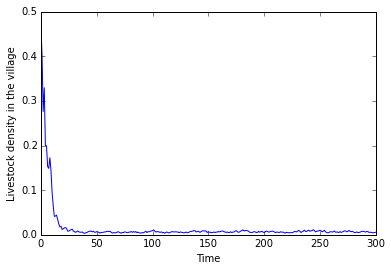

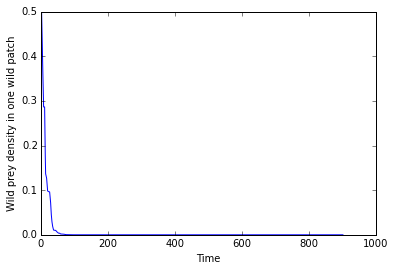

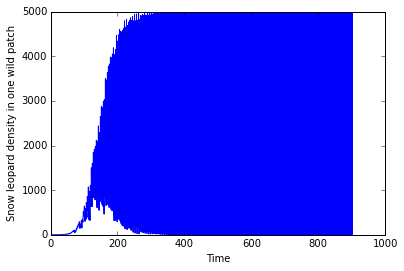

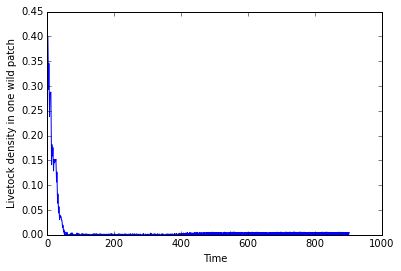

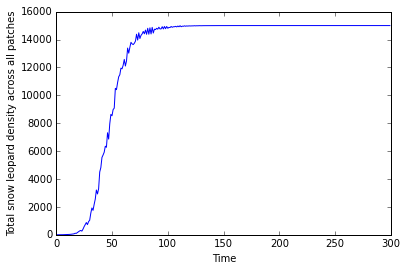

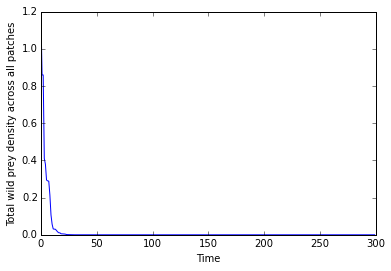

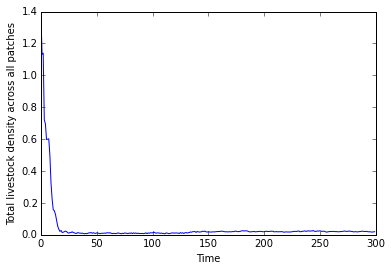

In [5]:
#Initial conditions for one instance
InitW=[[0.5],[1],[0.4]]
InitV=[[0],[0.4]]

#List of initial conditions for all instances of objects
initCondnsW=[]
initCondnsV=[]

#Time series for one instance of the class.
timeSeriesW=[[],[],[]]
timeSeriesV=[[],[]]

#Time series of all instances of the class.
overallTSW=[]
overallTSV=[]

#List of all instances of the class
wildHabitats=[]
villageHabitats=[]

#Parameters to be passed to the classes
a=0.5
b=0.2
c=0.2
e=0.01
fW=0.5
fV=0
j=1.1
g=1.5
p=2
K=500
r=0.5
m=0.1
        
dt=0.001

#parmsW - parameters for the Wild class. parmsV - parameters for the Village class.
parmsW=[a,b,c,e,fW,j,g,p,K,r,m,dt]
parmsV=[a,b,c,e,fV,j,g,p,K,r,m,dt]

#wildNo - keeping track of which instance are we dealing with.
# Initiate the instances, pass the initial conditions

for wildNo in range(3):
    initCondnsW.append(InitW)
    initCondnsV.append(InitV)
    
    overallTSW.append(timeSeriesW)
    overallTSV.append(timeSeriesV)
    
    wild=Wild(initCondnsW[wildNo],overallTSW,wildNo)
    wildHabitats.append(wild)
    
#Since there is only one village instance, I initiate that separately

village=Village(initCondnsV[0],overallTSV[0])
villageHabitats.append(village)

#Lists storing the total densities across all patches
totalSL=[]
totalWP=[]
totalLS=[]

#the final loop to execute the dynamics.
#disRate=0.261

t=0
tmax=300 # total number of time-steps
for t in range(tmax):
    disRate=random.uniform(0,0.5) # random dispersal rate between 0 and 0.5
    for wildNo in range(len(wildHabitats)):
        wildHabitats[wildNo].update(overallTSV[0],overallTSW,disRate,parmsW,wildNo)
    village.update(overallTSV[0],overallTSW,disRate,parmsV)
    #Appending the total densities across patches
    totalSL.append(overallTSW[0][1][len(overallTSW[0][1])-1]+overallTSW[1][1][len(overallTSW[1][1])-1]+overallTSW[2][1][len(overallTSW[2][1])-1])
    totalWP.append(overallTSW[0][0][len(overallTSW[0][0])-1]+overallTSW[1][0][len(overallTSW[1][0])-1]+overallTSW[2][0][len(overallTSW[2][0])-1])
    totalLS.append(overallTSW[0][2][len(overallTSW[0][2])-1]+overallTSW[1][2][len(overallTSW[1][2])-1]+overallTSW[2][2][len(overallTSW[2][2])-1]+overallTSV[0][1][len(overallTSV[0][1])-1])

plot(overallTSV[0][1])
xlabel("Time")
ylabel("Livestock density in the village")
figure()
plot(overallTSW[0][0])
xlabel("Time")
ylabel("Wild prey density in one wild patch")
figure()
plot(overallTSW[0][1])
xlabel("Time")
ylabel("Snow leopard density in one wild patch")
figure()
plot(overallTSW[0][2])
xlabel("Time")
ylabel("Livetock density in one wild patch")
figure()
plot(totalSL)
xlabel("Time")
ylabel("Total snow leopard density across all patches")
figure()
plot(totalWP)
xlabel("Time")
ylabel("Total wild prey density across all patches")
figure()
plot(totalLS)
xlabel("Time")
ylabel("Total livestock density across all patches")
figure()


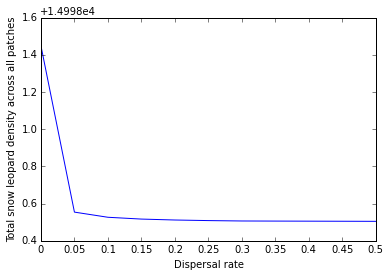

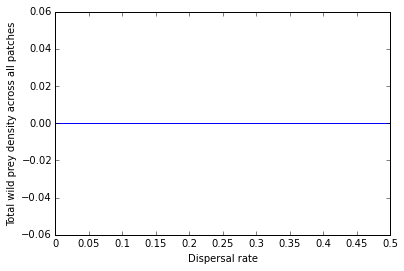

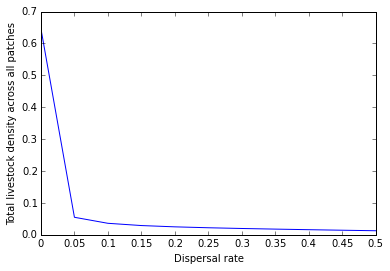

In [23]:
#In the previous cell, dispersal rate was randomly determined. Here, we fix the dispersal rate across iterations. However, we
#change the disper
t=0
tmax=1000 # total number of time-steps

# Lists for storing total density across patches
totalSL=[]
totalWP=[]
totalLS=[]

#Lists for storing end values of total densities at each dispersal rate
disTotalSL=[]
disTotalWP=[]
disTotalLS=[]
disRate=0
disRateList=[]

while disRate<0.51: 
    for t in range(tmax):
        for wildNo in range(len(wildHabitats)):
            wildHabitats[wildNo].update(overallTSV[0],overallTSW,disRate,parmsW,wildNo)
        village.update(overallTSV[0],overallTSW,disRate,parmsV)
        #Appending the total densities across patches
        totalSL.append(overallTSW[0][1][len(overallTSW[0][1])-1]+overallTSW[1][1][len(overallTSW[1][1])-1]+overallTSW[2][1][len(overallTSW[2][1])-1])
        totalWP.append(overallTSW[0][0][len(overallTSW[0][0])-1]+overallTSW[1][0][len(overallTSW[1][0])-1]+overallTSW[2][0][len(overallTSW[2][0])-1])
        totalLS.append(overallTSW[0][2][len(overallTSW[0][2])-1]+overallTSW[1][2][len(overallTSW[1][2])-1]+overallTSW[2][2][len(overallTSW[2][2])-1]+overallTSV[0][1][len(overallTSV[0][1])-1])
    disTotalSL.append(totalSL[len(totalSL)-1])
    disTotalWP.append(totalWP[len(totalWP)-1])
    disTotalLS.append(totalLS[len(totalLS)-1])
    disRateList.append(disRate)
    disRate=disRate+0.05
    
    
plot(disRateList,disTotalSL)
xlabel("Dispersal rate")
ylabel("Total snow leopard density across all patches")
xticks(disRateList,["0", "0.05", "0.1", "0.15", "0.2", "0.25", "0.3", "0.35", "0.4", "0.45", "0.5"])
figure()
plot(disRateList,disTotalWP)
xlabel("Dispersal rate")
ylabel("Total wild prey density across all patches")
xticks(disRateList,["0", "0.05", "0.1", "0.15", "0.2", "0.25", "0.3", "0.35", "0.4", "0.45", "0.5"])
figure()
plot(disRateList,disTotalLS)
xlabel("Dispersal rate")
ylabel("Total livestock density across all patches")
xticks(disRateList,["0", "0.05", "0.1", "0.15", "0.2", "0.25", "0.3", "0.35", "0.4", "0.45", "0.5"])
figure()

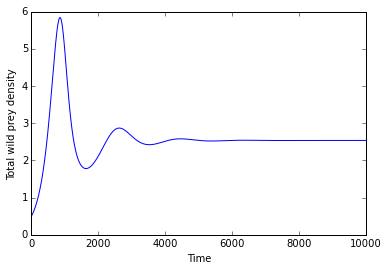

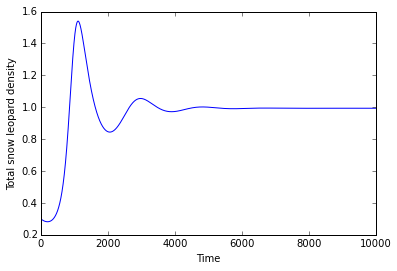

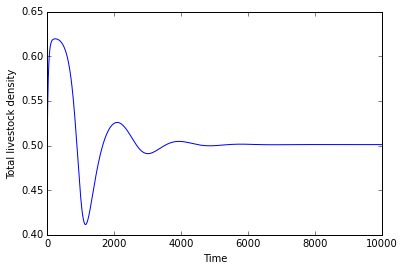

In [21]:
#To find the role of space, I compare the model above to a model with just ordianry differential equations, assuming a
#homogeneous and well-mixed system.

#parameters
a=0.5
b=0.2
c=0.2
e=0.01
fW=0.5
fV=0
j=1.1
g=1.5
p=2
K=500
r=0.5
m=0.1

#Initial condition
x=0.5
y=0.3
z=0.5

#Array to store final value
X=[]
Y=[]
Z=[]

#Final loop
dt=0.01
for t in range(10000):
    dx=(r*x*(1-((x+j*z)/K))*dt)-(a*x*y*dt)
    dy=(c*a*(x+z)-m-b*y-e*z)*y*dt
    dz=(p-fW*y-2*g*z)*dt
        
    x=x+dx
    y=y+dy
    z=z+dz
    Y.append(y)
    X.append(x)
    Z.append(z)

#plots    
plot(X)
xlabel("Time")
ylabel("Total wild prey density ")
figure()
plot(Y)
xlabel("Time")
ylabel("Total snow leopard density ")
figure()
plot(Z)
xlabel("Time")
ylabel("Total livestock density ")


In [85]:
print(Z)

[]
